<a href="https://colab.research.google.com/github/Matvezy/Body-Mesurments/blob/master/TestFront.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/AI_500_512px_SizesOnly_Aligned

/content/gdrive/MyDrive/AI_500_512px_SizesOnly_Aligned


In [3]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [4]:
class Transforms():
    def __init__(self):
        pass
    
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        image, landmarks = self.resize(image, landmarks, (512, 512))
        
        image = TF.to_tensor(image)
        #image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [5]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('trainFront.xml')
        root = tree.getroot()
        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        for filename in root[1]:
            self.image_filenames.append(filename.attrib['file'])
            #self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(6):
                x_coordinate = int(filename[num].attrib['x'])
                y_coordinate = int(filename[num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        if self.transform:
            image, landmarks = self.transform(image, landmarks)

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

In [6]:
class Network(nn.Module):
    def __init__(self,num_classes=12):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x





Loss: 3.2868733406066895
Total number of test images: 28
Elapsed Time : 2.496905565261841


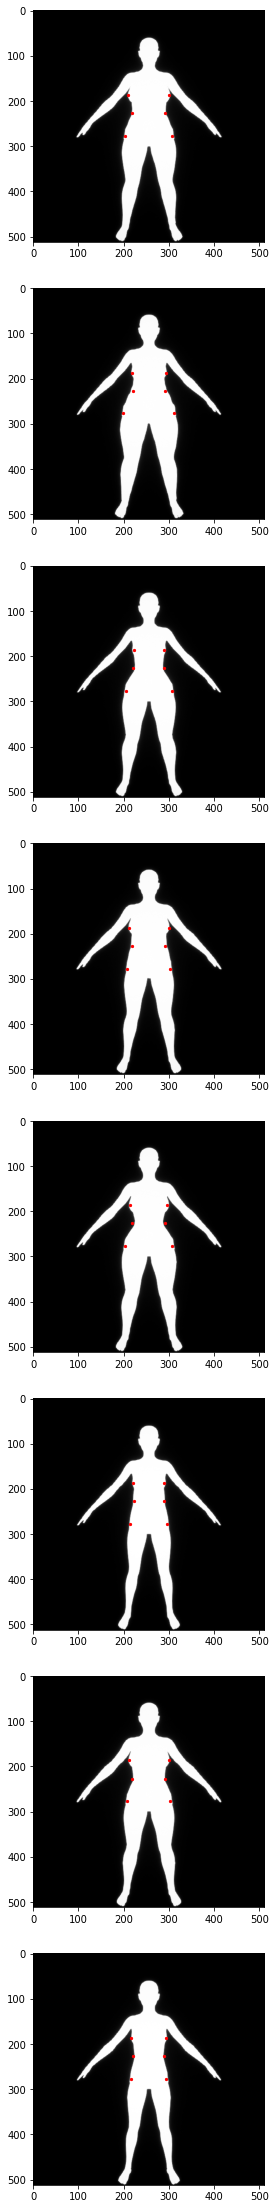

In [27]:
criterion = nn.MSELoss()
start_time = time.time()
train_loader = torch.utils.data.DataLoader(dataset, batch_size=18, shuffle=True, num_workers=4)
with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/gdrive/MyDrive/AI_1050_512px_SizesRelative_Aligned/front_landmarks5.pth')) 
    best_network.eval()
    for images, landmarks in train_loader:
          if torch.cuda.is_available():
            images = images.cuda()
            landmarks = (landmarks )

    predictions = (best_network(images).cpu())
    predictions = predictions.view(-1,6,2)

    loss_valid_step = criterion(predictions, landmarks)
    print('\n')
    print('\n')
    print("Loss: " + str(loss_valid_step.item()))
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        #plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)
print('Total number of test images: {}'.format(len(train_loader)))
end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 